# HW2: Gene Expression Data and Election Polls

## Introduction
“一个图表最有价值的是它强迫我们注意到我们始终不曾希望看到的内容”。这次作业中，我们会继续用数据分析工具，但是这次使用新的数据集： [gene expression](http://en.wikipedia.org/wiki/Gene_expression) and polls from the [2012 Presidental Election](http://en.wikipedia.org/wiki/United_States_presidential_election,_2012) and from the [2014 Senate Midterm Elections](http://en.wikipedia.org/wiki/United_States_Senate_elections,_2014).   

**第一**：你需要使用探索性数据分析，然后对gene expression数据矩阵使用奇异值分解（SVD）技术，从而决定是否基因表达样品的处理日期对数据中看到的变异性有很大影响。

**第二**：你要使用2012年总统选举的投票数据，决定（1）总统选举的民调机构有偏见吗？（2）多次民调的平均值是否比一次民调更好？

**第三**：你将使用[HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) 来抓取2014年参议院中期选举的投票数，并提供每个州的结果的初步预测。


#### Data
我们将使用以下数据集：

1. A gene expression data set called `exprs_GSE5859.csv` and sample annotation table called `sampleinfo_GSE5859.csv` which are both available on Github in the 2014_data repository: [expression data set](https://github.com/cs109/2014_data/blob/master/exprs_GSE5859.csv) and [sample annotation table](https://github.com/cs109/2014_data/blob/master/sampleinfo_GSE5859.csv).  

2. Polls from the [2012 Presidential Election: Barack Obama vs Mitt Romney](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama). The polls we will use are from the [Huffington Post Pollster](http://elections.huffingtonpost.com/pollster).  

3. Polls from the [2014 Senate Midterm Elections](http://elections.huffingtonpost.com/pollster) from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api). 


## Load Python modules

In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import requests 
from io import StringIO,BytesIO
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
import datetime as dt # module for manipulating dates and times
import numpy.linalg as lin # module for performing linear algebra operations

In [2]:
# special matplotlib argument for improved plots
from matplotlib import rcParams

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'

D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## 问题1
In this problem we will be using a [gene expression](http://en.wikipedia.org/wiki/Gene_expression) data set obtained from a [microarray](http://en.wikipedia.org/wiki/DNA_microarray) experiement [Read more about the specific experiment here](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE5859).  There are two data sets we will use:  

1. 在微阵列（基因）的行表达一个基因的特征，列表达不同的微阵列样本。
2. 关于每个样本（gene expression数据集的列）的信息的表，例如性别、年龄、治疗状态、样品被处理的日期。每行代表一个样本。


#### 问题 1(a) 
Read in the two files from Github: [exprs_GSE5859.csv](https://github.com/cs109/2014_data/blob/master/exprs_GSE5859.csv) and [sampleinfo_GSE5859.csv](https://github.com/cs109/2014_data/blob/master/sampleinfo_GSE5859.csv) as pandas DataFrames called `exprs` and `sampleinfo`. Use the gene names as the index of the `exprs` DataFrame.

In [37]:
# your code here
url_exprs = 'https://github.com/cs109/2014_data/blob/master/exprs_GSE5859.csv'
local_path_exprs = 'D:\\我的文档\\GitHub\\cs109_2015\\homework-2014\\2014_data\\exprs_GSE5859.csv'
exprs = pd.read_csv(local_path_exprs, index_col=0)

url_sampleinfo = "https://github.com/cs109/2014_data/blob/master/sampleinfo_GSE5859.csv"
local_path_sampleinfo = 'D:\\我的文档\\GitHub\\cs109_2015\\homework-2014\\2014_data\\sampleinfo_GSE5859.csv'
sampleinfo = pd.read_csv(local_path_sampleinfo)

确保基因表达式的DataFrame中的列顺序与样本注释DataFrame中的文件名顺序相匹配。如果`exprs`DataFrame的列顺序和`sampleinfo`的文件名顺序，将`exprs`DataFrame中的列重新排序。

**注意**：`exprs`DataFrame的列名称是获得这些数据的原始文件的文件名。

**提示**：方法`list.index(x)`可以用来返回一个`list`中首次出现项`x`的位置索引。如果没有该项则返回`error`。为了检查是否`exprs`中的列是否和`sampleinfo`中的行的顺序一致，可以使用方法`.all()`来返回一个布尔结果或者一个布尔结果的列表。
示例代码：`(exprs.columns == sampleinfo.filename).all()`

In [38]:
# your code here
(exprs.columns == sampleinfo.filename).all()

False

检查在`sampleinfo.filename`列中的值和`expres.columns`一致的名字。

In [40]:
sampleinfo[exprs.columns == sampleinfo.filename]

,ethnicity,date,filename,sex
23,CEU,2002-11-21,GSM25482.CEL.gz,F


In [46]:
# your code here
a = sampleinfo.filename.tolist()
b = list(exprs.columns)

matchIndex = [b.index(x) for x in a]
exprs = exprs[matchIndex]

# check if all the column names match the file names in sampleinfo
(exprs.columns == sampleinfo.filename).all()

True

展示两个DataFrame的表头：`exprs`和`sampleinfo`。

In [49]:
# your code here
exprs.head()

,GSM25349.CEL.gz,GSM25350.CEL.gz,GSM25356.CEL.gz,GSM25357.CEL.gz,GSM25358.CEL.gz,GSM25359.CEL.gz,GSM25360.CEL.gz,GSM25361.CEL.gz,GSM25377.CEL.gz,GSM25378.CEL.gz,...,GSM136719.CEL.gz,GSM136720.CEL.gz,GSM136721.CEL.gz,GSM136722.CEL.gz,GSM136723.CEL.gz,GSM136724.CEL.gz,GSM136725.CEL.gz,GSM136726.CEL.gz,GSM136727.CEL.gz,GSM136729.CEL.gz
1007_s_at,6.627014,6.249807,5.934128,6.145268,6.091270,6.041186,6.050375,6.063847,6.226106,6.358282,...,6.466445,6.533592,6.631492,6.513362,6.440706,6.704324,6.488579,6.809481,6.133068,6.155473
1053_at,6.939184,6.818038,7.047962,7.422477,7.272361,7.128216,6.750719,6.836287,6.738022,7.367895,...,7.032885,7.156344,7.018025,6.973322,6.884738,7.120898,7.517410,7.200596,7.280781,7.111583
117_at,5.113570,5.074096,5.371201,5.266550,5.342047,5.063876,5.315898,5.483652,6.689444,6.482782,...,5.661112,5.127260,5.151840,5.505602,5.687689,4.942651,5.247190,5.237239,5.401876,5.302628
121_at,7.833862,7.780682,7.458197,7.655948,7.546555,7.072670,7.092984,6.954225,7.489785,7.388539,...,7.769734,7.815864,7.683279,7.883231,7.913621,7.834196,7.331864,7.357102,7.607461,7.456453
1255_g_at,3.152269,3.111747,3.018932,3.154545,3.107954,3.224284,3.114241,3.044975,3.304038,2.887919,...,3.257484,3.339234,3.298384,3.150654,3.344501,3.230285,3.175846,3.105092,3.225123,3.090149


In [51]:
sampleinfo.head()

,ethnicity,date,filename,sex
0,CEU,2003-02-04,GSM25349.CEL.gz,M
1,CEU,2003-02-04,GSM25350.CEL.gz,M
2,CEU,2002-12-17,GSM25356.CEL.gz,M
3,CEU,2003-01-30,GSM25357.CEL.gz,M
4,CEU,2003-01-03,GSM25358.CEL.gz,M


#### 问题1(b)
从`sampleinfo`表中抽取年和月作为整数类型。

**提示**：将一个Series或DataFrame中的一列转换为date-like object，你可以使用`to_datetime`函数。这会创造一个`DatetimeIndex`，它可以用来抽取DataFrame每行数据中的月和年。

In [55]:
# your code here
sampleinfo['date'] = pd.to_datetime(sampleinfo.date)
sampleinfo['month'] = sampleinfo.date.apply(lambda x: x.month)
sampleinfo['year'] = list(map(lambda x: x.year, sampleinfo.date))

In [56]:
sampleinfo.head()

,ethnicity,date,filename,sex,month,year
0,CEU,2003-02-04,GSM25349.CEL.gz,M,2,2003
1,CEU,2003-02-04,GSM25350.CEL.gz,M,2,2003
2,CEU,2002-12-17,GSM25356.CEL.gz,M,12,2002
3,CEU,2003-01-30,GSM25357.CEL.gz,M,1,2003
4,CEU,2003-01-03,GSM25358.CEL.gz,M,1,2003


#### 问题1（c）
从`sampleinfo`表中的`date`列中，转换日期格式到距离2002年10月31日的天数，在`sampleinfo`DataFrame中增加一列名为`elapsedInDays`存储这个转换的天数记录。展示转换后的`sampleinfo`表头。

**提示**：使用`datetime`模块创造一个新的表示2002年10月31日的`datetime`对象。然后，从`date`列中依次减去这个对象即可。

In [58]:
# your code here
oct31 = dt.datetime(2002, 10, 31, 0, 0)
oct31

datetime.datetime(2002, 10, 31, 0, 0)

In [59]:
sampleinfo['elapsedInDays'] = sampleinfo.date.apply(lambda x: (x - oct31).days)
sampleinfo.head()

,ethnicity,date,filename,sex,month,year,elapsedInDays
0,CEU,2003-02-04,GSM25349.CEL.gz,M,2,2003,96
1,CEU,2003-02-04,GSM25350.CEL.gz,M,2,2003,96
2,CEU,2002-12-17,GSM25356.CEL.gz,M,12,2002,47
3,CEU,2003-01-30,GSM25357.CEL.gz,M,1,2003,91
4,CEU,2003-01-03,GSM25358.CEL.gz,M,1,2003,64


#### 问题1（d）
使用探索性分析和基因表达数据矩阵的奇异值分解（SVD）来确定样本的处理日期是否对数据中看到的变异性有很大的影响，或者只是种族（与日期混淆）。

**Hint**: See the end of the [lecture from 9/23/2014 for help with SVD](http://nbviewer.ipython.org/github/cs109/2014/blob/master/lectures/lecture07/data_scraping_transcript.ipynb). 

First subset the the `sampleinfo` DataFrame to include only the CEU ethnicity.  Call this new subsetted DataFrame `sampleinfoCEU`.  Show the head of `sampleinfoCEU` DataFrame. 

In [60]:
# your code here
sampleinfoCEU = sampleinfo[sampleinfo.ethnicity == 'CEU']
sampleinfoCEU.head()

,ethnicity,date,filename,sex,month,year,elapsedInDays
0,CEU,2003-02-04,GSM25349.CEL.gz,M,2,2003,96
1,CEU,2003-02-04,GSM25350.CEL.gz,M,2,2003,96
2,CEU,2002-12-17,GSM25356.CEL.gz,M,12,2002,47
3,CEU,2003-01-30,GSM25357.CEL.gz,M,1,2003,91
4,CEU,2003-01-03,GSM25358.CEL.gz,M,1,2003,64


接下来，将exprs DataFrame的子集只包含具有CEU种族的样本。命名这个新的子集的DataFrame`exprsCEU`。显示`exprsCEU`DataFrame的头。

In [61]:
# your code here
exprsCEU = exprs[sampleinfoCEU.filename]
exprsCEU.head()

,GSM25349.CEL.gz,GSM25350.CEL.gz,GSM25356.CEL.gz,GSM25357.CEL.gz,GSM25358.CEL.gz,GSM25359.CEL.gz,GSM25360.CEL.gz,GSM25361.CEL.gz,GSM25377.CEL.gz,GSM25378.CEL.gz,...,GSM48658.CEL.gz,GSM48660.CEL.gz,GSM48661.CEL.gz,GSM48662.CEL.gz,GSM48663.CEL.gz,GSM48664.CEL.gz,GSM48665.CEL.gz,GSM136725.CEL.gz,GSM136726.CEL.gz,GSM136727.CEL.gz
1007_s_at,6.627014,6.249807,5.934128,6.145268,6.091270,6.041186,6.050375,6.063847,6.226106,6.358282,...,6.501510,6.558100,6.618286,6.869995,5.981000,6.403285,6.248702,6.488579,6.809481,6.133068
1053_at,6.939184,6.818038,7.047962,7.422477,7.272361,7.128216,6.750719,6.836287,6.738022,7.367895,...,7.066686,7.386702,6.407958,7.089180,7.120923,7.018998,7.155419,7.517410,7.200596,7.280781
117_at,5.113570,5.074096,5.371201,5.266550,5.342047,5.063876,5.315898,5.483652,6.689444,6.482782,...,5.600514,5.232676,5.630720,4.944748,5.275577,5.770358,5.616842,5.247190,5.237239,5.401876
121_at,7.833862,7.780682,7.458197,7.655948,7.546555,7.072670,7.092984,6.954225,7.489785,7.388539,...,7.437535,7.714650,7.416252,7.746448,8.001434,7.626723,7.452299,7.331864,7.357102,7.607461
1255_g_at,3.152269,3.111747,3.018932,3.154545,3.107954,3.224284,3.114241,3.044975,3.304038,2.887919,...,3.009983,3.151203,3.199709,3.159496,3.149710,3.242780,3.433125,3.175846,3.105092,3.225123


检查以确保`exprsCEU` DataFrame中的列的顺序与`sampleinfoCEU` DataFrame中的行匹配。

In [62]:
# your code here
(exprsCEU.columns == sampleinfoCEU.filename).all()

True

计算所有样本中`exprsCEU`DataFrame中的平均基因表达强度。对于`exprsCEU`DataFrame中的每个样本，从每个样本中减去平均基因表达强度。显示平均归一化基因表达数据的头。

In [63]:
# your code here
data = exprsCEU.apply(lambda x: x - exprsCEU.mean(axis=1), axis=0)
data.head()

,GSM25349.CEL.gz,GSM25350.CEL.gz,GSM25356.CEL.gz,GSM25357.CEL.gz,GSM25358.CEL.gz,GSM25359.CEL.gz,GSM25360.CEL.gz,GSM25361.CEL.gz,GSM25377.CEL.gz,GSM25378.CEL.gz,...,GSM48658.CEL.gz,GSM48660.CEL.gz,GSM48661.CEL.gz,GSM48662.CEL.gz,GSM48663.CEL.gz,GSM48664.CEL.gz,GSM48665.CEL.gz,GSM136725.CEL.gz,GSM136726.CEL.gz,GSM136727.CEL.gz
1007_s_at,0.365059,-0.012149,-0.327827,-0.116687,-0.170685,-0.220769,-0.211580,-0.198109,-0.035849,0.096327,...,0.239554,0.296144,0.356331,0.608040,-0.280956,0.141330,-0.013254,0.226624,0.547526,-0.128887
1053_at,-0.136032,-0.257178,-0.027254,0.347260,0.197144,0.053000,-0.324497,-0.238930,-0.337195,0.292678,...,-0.008531,0.311485,-0.667259,0.013964,0.045706,-0.056219,0.080203,0.442193,0.125379,0.205564
117_at,-0.490556,-0.530031,-0.232926,-0.337577,-0.262080,-0.540250,-0.288228,-0.120475,1.085317,0.878655,...,-0.003613,-0.371451,0.026594,-0.659379,-0.328549,0.166231,0.012716,-0.356936,-0.366887,-0.202251
121_at,0.418026,0.364847,0.042362,0.240113,0.130720,-0.343165,-0.322852,-0.461611,0.073949,-0.027296,...,0.021700,0.298814,0.000417,0.330612,0.585598,0.210887,0.036463,-0.083972,-0.058733,0.191626
1255_g_at,0.018335,-0.022187,-0.115002,0.020611,-0.025980,0.090351,-0.019693,-0.088959,0.170104,-0.246015,...,-0.123951,0.017269,0.065775,0.025562,0.015776,0.108846,0.299192,0.041912,-0.028842,0.091189


使用这个平均归一化基因表达数据，计算到第一主成分（PC1）的投影。

**Hint**: Use the `numpy.linalg.svd()` function in the `numpy.linalg` module (or the `scipy.linalg.svd()` function in the `scipy.linalg` module) to apply an [singular value decomposition](http://en.wikipedia.org/wiki/Singular_value_decomposition) to a matrix.  

In [64]:
# your code here
U, s, Vh = lin.svd(data.values)

In [70]:
V = Vh.T

使用PC1的值创建直方图。使用25的bin尺寸。

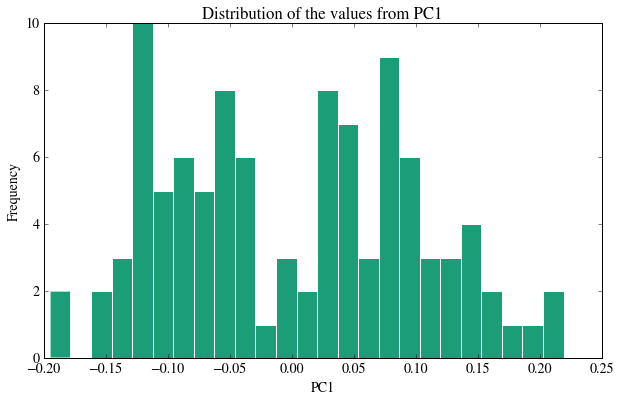

In [71]:
# your code here
plt.hist(V[:, 0], bins=25)
plt.xlabel('PC1')
plt.ylabel('Frequency')
plt.title('Distribution of the values from PC1')

创建散点图，x轴表示自2002年10月31日以来的天数，y轴表示PC1的值。

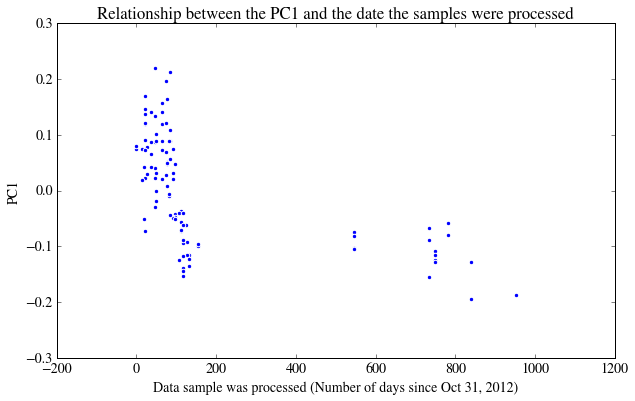

In [72]:
# your code here
plt.scatter(sampleinfoCEU.elapsedInDays, V[:, 0])
plt.xlabel('Data sample was processed (Number of days since Oct 31, 2012)')
plt.ylabel('PC1')
plt.title('Relationship between the PC1 and the date the samples were processed')

你在什么日子注意到被处理的样本的差异？

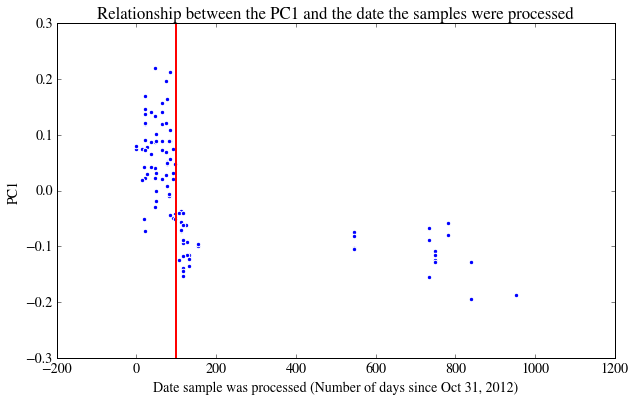

In [75]:
# your code here
plt.scatter(sampleinfoCEU.elapsedInDays, V[:, 0])
# plt.xlim(0, 300)
plt.xlabel('Date sample was processed (Number of days since Oct 31, 2012)')
plt.ylabel('PC1')
plt.title('Relationship between the PC1 and the date the samples were processed')
plt.axvline(x=100, color='r')

## Discussion for Problem 1

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*
通过计算基因表达数据矩阵的SVD，我们可以发现样本被处理的日期对样本是否发生变异产生了很大影响。这个可以通过问题1（d）的散点图可以看出，其中在第100天发生了明显的变化。


---

## 问题2：是否民调机构在总统大选中有自己的喜好？

#### 问题2（a）

The [HuffPost Pollster](http://elections.huffingtonpost.com/pollster) contains many political polls. You can access these polls from individual races as a CSV but you can also access polls through the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) to access the data.  

Read in the polls from the [2012 Presidential Election: Barack Obama vs Mitt Romney](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama) into a pandas DataFrame called `election`. For this problem, you may read in the polls for this race directly using [the CSV file](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.csv) available from the HuffPost Pollster page.

In [77]:
# your code here
url = "http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.csv"
source = requests.get(url).text
s = StringIO(source)
election = pd.DataFrame.from_csv(s, index_col=None).convert_objects(
            convert_dates="coerce", convert_numeric=True) # Access polls as a CSV file

D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


展示`election`DataFrame的表头。

In [78]:
# your code here
election.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Other,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06 08:40:26,1000.0,Likely Voters,Live Phone,47.0,47.0,6.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.politico.com/news/stories/1112/8338...,Nonpartisan,None,NaN,1
1,YouGov/Economist,2012-11-03,2012-11-05,2012-11-26 15:31:23,740.0,Likely Voters,Internet,49.0,47.0,3.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://cdn.yougov.com/cumulus_uploads/document...,Nonpartisan,None,NaN,1
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06 09:22:02,872.0,Likely Voters,Automated Phone,48.0,48.0,4.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.gravispolls.com/2012/11/gravis-mark...,Nonpartisan,None,NaN,1
3,IBD/TIPP,2012-11-03,2012-11-05,2012-11-06 08:51:48,712.0,Likely Voters,Live Phone,50.0,49.0,NaN,1.0,http://elections.huffingtonpost.com/pollster/p...,http://news.investors.com/special-report/50841...,Nonpartisan,None,NaN,1
4,Rasmussen,2012-11-03,2012-11-05,2012-11-06 08:47:50,1500.0,Likely Voters,Automated Phone,48.0,49.0,NaN,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.rasmussenreports.com/public_content...,Nonpartisan,None,NaN,1


十一月进行多少次民意调查？将此数字定义为M. 

**提示**：选择`election`DataFrame中`Start Date`列中在2012年11月的日期的行。

In [85]:
# your code here
# filtered = election[list(map(lambda x: (x.month == 11) & (x.year == 2012), election['Start Date']))]
filtered = election[election['Start Date'].apply(lambda x: (x.month == 11) & (x.year == 2012))]
filtered.drop_duplicates('Pollster', inplace=1)
M = len(filtered)
print('Number of polls in November: {:d}'.format(M))

Number of polls in November: 18


D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\pandas\util\decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


十一月所有民意调查人数的中位数是多少？将此数量定义为N.

In [86]:
# your code here
N = np.median(filtered['Number of Observations'])
print(N)

1200.0


#### 问题2（b）
使用问题1（a）中的中值样本大小N，模拟单次投票的结果：模拟奥巴马在样本N中获得的投票数，其中p = 0.53是投票给奥巴马的选民的百分比。

**提示**：Use the binomial distribution with parameters $N$ and $p$ = 0.53. 

In [88]:
# your code here
p = 0.53
print('Simulated number of votes for Obama: {}'.format(np.random.binomial(N, p, size=1)))

Simulated number of votes for Obama: [634]


现在，执行蒙特卡罗模拟以获得具有样本大小N的奥巴马投票的估计百分比，其中N是问题2（a）中计算的中值样本大小。让p = 0.53是选民投票给奥巴马的百分比。

**提示**：您将重复1000次以上的模拟，并从单次投票中绘制奥巴马获得的投票的百分比的分布。您模拟的单个投票的结果是随机变量，每次您抽样时都会有所不同。

In [113]:
# your code here
p = 0.53
B = 1000
obs = np.random.binomial(N, p, size=B)
obs.shape

(1000,)

In [114]:
obs = obs / N
obs[:10]

array([ 0.52583333,  0.55166667,  0.54333333,  0.53666667,  0.54      ,
        0.5175    ,  0.54      ,  0.53583333,  0.52      ,  0.54416667])

利用公式知道二项分布的期望和方差值。
$$E(X) = p$$ 
and 
$$Var(X) = p(1-p)$$

从单次投票中分析奥巴马获得的投票的估计百分比。奥巴马投票的估计百分比的分布是多少？

In [99]:
# your code here
p = 0.53
B = 1000
obs = list(map(lambda x: np.mean(np.random.binomial(1, p, size=N)), range(B)))

D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(array([   8.,   24.,   85.,  184.,  243.,  221.,  146.,   64.,   18.,    7.]),
 array([ 0.48666667,  0.49566667,  0.50466667,  0.51366667,  0.52266667,
         0.53166667,  0.54066667,  0.54966667,  0.55866667,  0.56766667,
         0.57666667]),
 <a list of 10 Patch objects>)

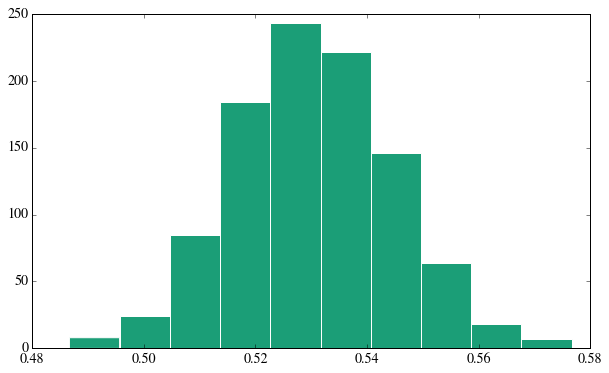

In [115]:
plt.hist(obs)

乍看起来，分布看起来是正太分布的。我们可以使用qqplot来视觉检查这个分布是否正常分布。 

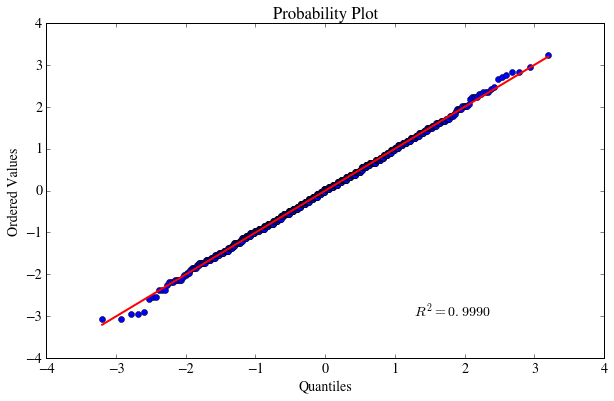

In [116]:
import scipy.stats as stats
stats.probplot((obs - np.mean(obs)) / np.std(obs, ddof=1), dist='norm', plot=plt)
plt.show()

从直方图和qqplot，我们看到分布看起来是正太分布。

从这些投票过程中的获得的估计的百分比的标准错误（SE）是多少。

**提示**：记住SE是随机变量分布的标准差（SD）。

In [122]:
# your code here
np.std(obs, ddof=1)

0.014270386154702953

From the lecture we saw if we observe $N$ Bernoulli random variables $(X_1, \ldots X_N)$, then 
$$ \mbox{E}(\bar{X}) = \frac{1}{N} \sum_{i=1}^N p = p$$
and 
$$\mbox{Var}(\bar{X})= \frac{1}{N^2} \sum_{i=1}^N p(1-p) = \frac{p(1-p)}{N}$$

In our example, we assume each $X_i$ is a Bernoulli distribution with $p$ = 0.53. Therefore, if $N$ = 1200, we can analytically calculate the standard deviation of $\bar{X}$ directly and compare to the standard error above

In [182]:
np.sqrt((0.53*0.47) / 1200)

0.014407752542757436

#### 问题2（c）
现在假设我们进行M次民意调查，其中M是指在11月发生的投票数（在问题2（a）中计算得到）。进行1000次模拟，然后计算每次模拟的M次民意调查的均值。

In [123]:
# your code here
print('Number of polls in November: {}'.format(M))
print('Median size of polls in November: {}'.format(N))

Number of polls in November: 18
Median size of polls in November: 1200.0


In [124]:
# Represents the percentage of Obama votes from M polls
def simulatedPolls(p, N, M):
    return list(map(lambda x: np.mean(np.random.binomial(1, p, N)), range(M)))

In [125]:
simulatedPolls(p, N, M)

D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


[0.54583333333333328,
 0.52249999999999996,
 0.54083333333333339,
 0.51500000000000001,
 0.53916666666666668,
 0.53333333333333333,
 0.55666666666666664,
 0.54583333333333328,
 0.52833333333333332,
 0.54166666666666663,
 0.55249999999999999,
 0.51500000000000001,
 0.54583333333333328,
 0.51916666666666667,
 0.55000000000000004,
 0.53916666666666668,
 0.53749999999999998,
 0.51333333333333331]

In [126]:
p = 0.53
B = 1000
mom = list(map(lambda y: np.mean(simulatedPolls(p, N, M)), range(B)))

D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


1000次民意调查的均值的分布是什么？

**提示**：用绘图来展示。

(array([  14.,   55.,   99.,  214.,  251.,  194.,  115.,   47.,    9.,    2.]),
 array([ 0.52074074,  0.5228287 ,  0.52491667,  0.52700463,  0.52909259,
         0.53118056,  0.53326852,  0.53535648,  0.53744444,  0.53953241,
         0.54162037]),
 <a list of 10 Patch objects>)

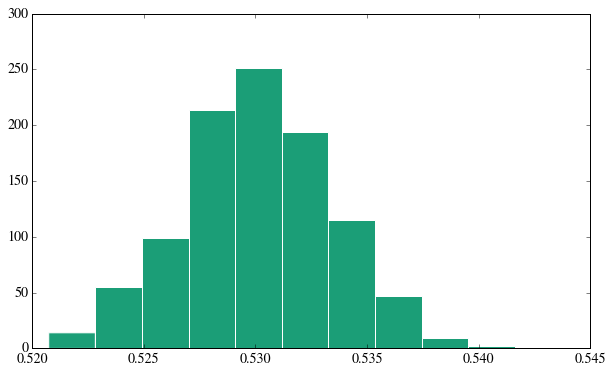

In [129]:
# your code here
plt.hist(mom)

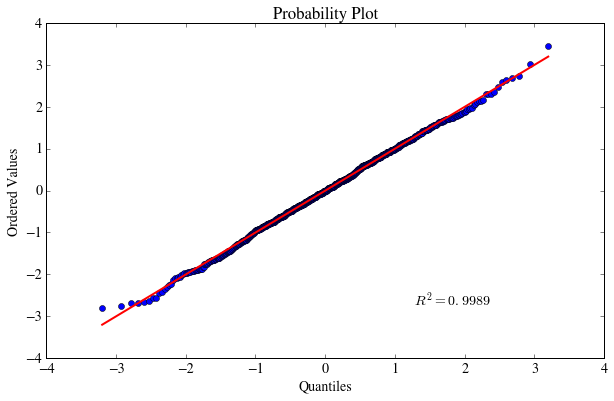

In [131]:
stats.probplot((mom-np.mean(mom)) / np.std(mom, ddof=1), dist='norm', plot=plt)
plt.show()

平均投票数的标准错误（SE）是什么？

In [132]:
# your code here
np.std(mom, ddof=1)

0.0033370581397801761

多次模拟的民意调查的均值的标准错误（SE）是大于还是等于还是小于单次模拟的标准差（SD）（在问题2（b）中计算）？差多少？

**提示**：计算两个量的比率。

In [183]:
# your code here
ratio = np.std(mom, ddof = 1) / np.std(obs, ddof = 1) 

print("The ratio of the SE of the average of polls to the SD of a single poll is %g" % ratio)

The ratio of the SE of the average of polls to the SD of a single poll is 0.233845


答案：民意调查的平均值的标准错误小于单次调查的标准差，factor约为4。

#### 问题2（d）
重复问题2（b），但是现在记录每次模拟的*across poll*标准差。

In [134]:
# your code here
B = 1000
p = 0.53
sds = list(map(lambda y: np.std(simulatedPolls(p, N, M), ddof=0), range(B)))

D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


What is the distribution of the across M polls standard deviation?

**提示**: Show a plot.

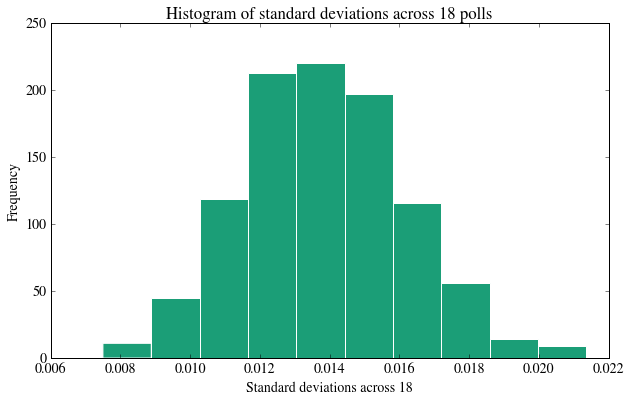

In [135]:
# your code here
plt.hist(sds)
plt.xlabel('Standard deviations across {}'.format(M))
plt.ylabel('Frequency')
plt.title('Histogram of standard deviations across {} polls'.format(M))

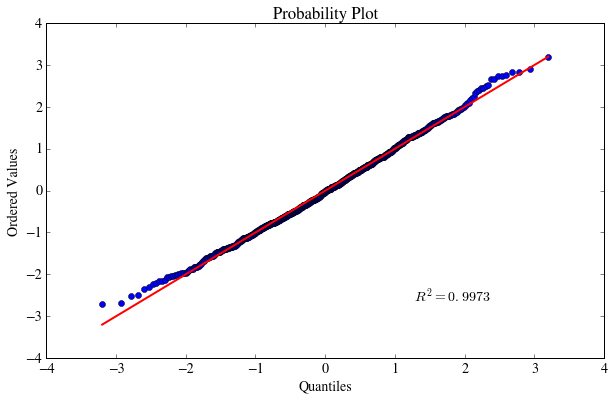

In [136]:
stats.probplot((sds - np.mean(sds)) / np.std(sds, ddof=1), dist='norm', plot=plt)
plt.show()

#### 问题2（e）
在2012年总统大选数据中，真实的M次民意调查的标准差是多少？

In [137]:
# your code here
thesd = np.std(filtered['Obama'] / 100, ddof=0)
thesd

0.010829771494232194

如果民意调查没有偏见，这是否比我们预期的更大，相同或更小。

In [139]:
# your code here
thesd / np.mean(sds)

0.78266834084098547

答：2012年真正的总统选举数据的标准偏差小于我们预期的民意调查的标准差均值，如果没有偏见的话。

比较2012年总统数据中M次民意调查的标准偏差的另一种方法是直接与`sds`的分布进行比较。我们可以计算一个p值或者观察到大于或等于`thesd`的概率。

In [141]:
np.mean(thesd > np.array(sds))

0.104

我们可以看到`thesd`服从`sds`的初始假设分布。

#### 问题2（f）
了解二项分布的正态近似，并分析导出问题2（b）和2（c）的结果（使用此近似）。将从分析获得的结果与从模拟获得的结果进行比较。

**Solution:** A random variable $X$ that has a [Binomial distribution](http://en.wikipedia.org/wiki/Binomial_distribution) with $N$ independent trials of a binary outcome (e.g. yes/no) each with probability of success $p$ can be [approximated by a normal distribution](http://en.wikipedia.org/wiki/Binomial_distribution#Normal_approximation) if $n$ is large enough. Another way of writing this is if $X$ has a Binomial distribution with parameters $N$ and $p$, $X \sim Bin(N,p)$, and $N$ is "large enough", then $X$ can be approximated by a normal distribution with mean $Np$ and variance $Np(1-p)$, or $X \sim Normal(Np, Np(1-p))$. 

In Problem 2(b), we are asking about the *percentage* of Obama votes, therefore we are actually interested in $Y_i = \frac{X_i}{N}$ where $X_i \sim Bin(N, p)$. In this case, $\mbox{Var}(Y_i)  = p(1-p)$. To estimate the standard deviation of $\bar{Y}$, 

$$\mbox{Var}(\bar{Y}) =  \frac{1}{N^2} \sum_{i=1}^N p(1-p) = \frac{p(1-p)}{N}$$

Thus, we can analytically compute the standard deviation of $\bar{Y}$ using $\sqrt{\frac{p(1-p)}{N}}$ and compare to the standard deviation obtained from simulations. 

In [142]:
# your code here
# Standard deviation from simulations in 2(b)
print('SD from simulations: {}'.format(np.std(obs, ddof=1)))

# Standard deviation computed analytically
print('SD using normal approximation {}'.format(np.sqrt(p * (1/p) / N)))

SD from simulations: 0.014270386154702953
SD using normal approximation 0.02886751345948129


In Problem 2(c), we are asking about the *percentage* of Obama votes from averaged across M polls.  Above we saw the variance for each poll is $\frac{p(1-p)}{N}$. Therefore we can treat the variance at the poll level as $\sigma_{poll}^2 = \frac{p(1-p)}{N}$. Then, when we average across M polls the variance becomes $\sigma_{poll}^2 / M = \frac{p(1-p)}{N \cdot M }$

In [143]:
# Standard deviation from simulations in 2(c) 
print("SD from simulations: %g" % np.std(mom, ddof=1))

# Standard deviation computed analytically
print("SD using normal approximation %g" % np.sqrt((p * (1-p)/ N) / M))

SD from simulations: 0.00333706
SD using normal approximation 0.00339594


## Discussion for Problem 2

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*
在这个问题中，我们分析在2012年11月所有的民意调查，在移除了同一调查机构的数据后，我们不能观察到任何机构的偏见。从概率的角度上说，2012年总统大选的投票标准差比我们期望（计算）的还小。

---

## 问题3：是否多次民意调查的平均值要好于一次民意调查？

#### 问题3（a）
大多数尚未决定的选民在选举中投票选出两名候选人之一。因此，被报告的百分比低估了两名候选人的最终价值。然而，如果我们假设将未定的选民均匀分割，则观察到的差异应该是对最终差异的无偏估计。

在`election`DataFrame中添加一个新列，其中包含奥巴马和Romeny之间的区别称为`diff`。

In [160]:
# your code here
election['Diff'] = (election.Obama / 100) - (election.Romney / 100)
election.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Other,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration,Diff
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06 08:40:26,1000.0,Likely Voters,Live Phone,47.0,47.0,6.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.politico.com/news/stories/1112/8338...,Nonpartisan,None,NaN,1,0.00
1,YouGov/Economist,2012-11-03,2012-11-05,2012-11-26 15:31:23,740.0,Likely Voters,Internet,49.0,47.0,3.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://cdn.yougov.com/cumulus_uploads/document...,Nonpartisan,None,NaN,1,0.02
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06 09:22:02,872.0,Likely Voters,Automated Phone,48.0,48.0,4.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.gravispolls.com/2012/11/gravis-mark...,Nonpartisan,None,NaN,1,0.00
3,IBD/TIPP,2012-11-03,2012-11-05,2012-11-06 08:51:48,712.0,Likely Voters,Live Phone,50.0,49.0,NaN,1.0,http://elections.huffingtonpost.com/pollster/p...,http://news.investors.com/special-report/50841...,Nonpartisan,None,NaN,1,0.01
4,Rasmussen,2012-11-03,2012-11-05,2012-11-06 08:47:50,1500.0,Likely Voters,Automated Phone,48.0,49.0,NaN,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.rasmussenreports.com/public_content...,Nonpartisan,None,NaN,1,-0.01


#### 问题3（b）
绘制选举之前一周的差异（例如5天），天数在x轴上，差异在y轴上。添加一条显示3.9％的水平线：奥巴马和罗姆尼在选举日时的差异。

In [161]:
# your code here
last_day = max(election['Start Date'])
filtered = election[election['Start Date'].apply(lambda x: (last_day - x).days <= 5)]
filtered.sort_values('Start Date', inplace=1)
days = filtered['Start Date'].apply(lambda x: (last_day - x).days)

D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [164]:
color_map = {}
for i, p in enumerate(set(filtered.Pollster)):
    color_map[p] = np.random.rand()

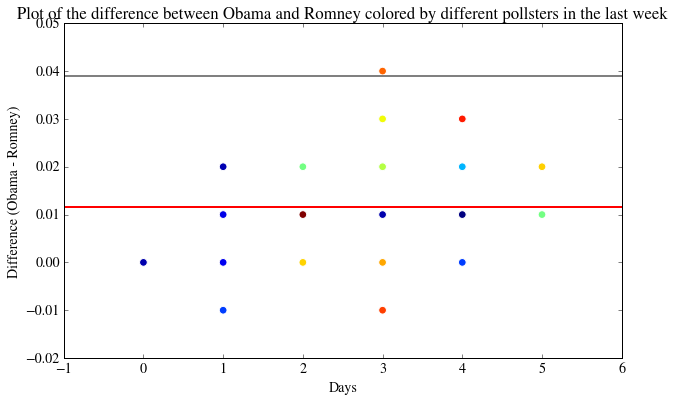

In [165]:
plt.scatter(days, filtered.Diff, c = list(map(lambda x: color_map[x], filtered.Pollster)), s=60)
plt.axhline(y=0.039, c='gray')
plt.axhline(y=np.mean(filtered.Diff), c='red')
plt.xlabel('Days')
plt.ylabel('Difference (Obama - Romney)')
plt.title('Plot of the difference between Obama and Romney colored by different pollsters in the last week')

#### 问题3（c）
绘制展示民调机构差异的图，其中民意调查机构在x轴上，差异在y轴上。

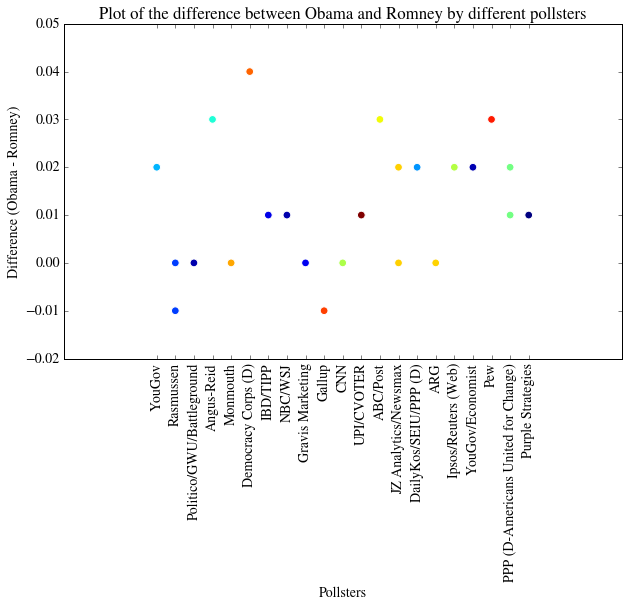

In [168]:
# your code here
pollster_map = {}

polls = list(set(filtered.Pollster))
for i, p in enumerate(polls):
    pollster_map[p] = i
    
plt.scatter(list(map(lambda x: pollster_map[x], filtered.Pollster)), filtered.Diff, 
                c=list(map(lambda x: color_map[x], filtered.Pollster)), s=60)
plt.xticks(range(len(polls)), polls, rotation=90)
plt.xlabel('Pollsters')
plt.ylabel('Difference (Obama - Romney)')
plt.title('Plot of the difference between Obama and Romney by different pollsters')
plt.show()

Is the across poll difference larger than the between pollster difference?

答案：对于这个问题，我们可以比较每个民调机构内的变异性（在一组调查结果之间比较）与其他民调机构之间的变异性。从这两个可视化来看，很明显，不同民调机构之间的差异较大。

#### 问题3（d）
取每个民调机构的多次民调结果的平均值，然后计算最终的平均值。鉴于这个差异，你对奥巴马的胜利有多信心？ 

**提示**：仅基于观察到的数据计算该平均值的标准错误估计值。

In [169]:
# your code here
aggr = filtered.groupby('Pollster').mean()
print('Average across pollsters: {}'.format(np.round(np.mean(aggr.Diff), 4)))
print('Standard error: {}'.format(np.std(aggr.Diff, ddof=0)))

Average across pollsters: 0.0124
Standard error: 0.012966903623038196


答：给定最大的标准错误，我对奥巴马的胜利不会非常的有信心。

#### 问题3（e）
显示不同时间的差异，看看是否可以检测到最终的趋势。使用这种趋势来看它是否提高了最终的估计。

D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


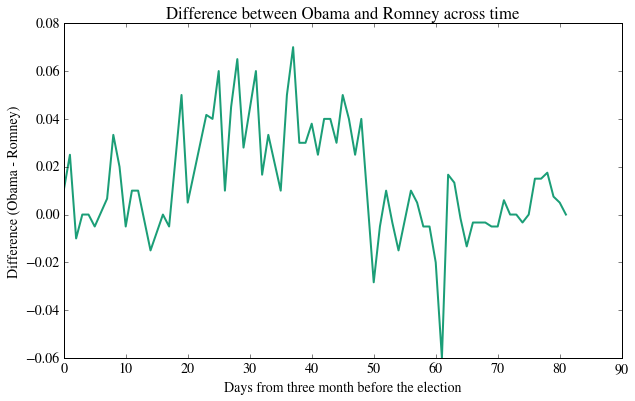

In [175]:
# your code here
three_months = dt.datetime(2012, 8, 15, 0, 0)

new_data = election[election['Start Date'].apply(lambda x: x >= three_months)]
new_data.sort_values('Start Date')
new_data['days'] = new_data['Start Date'].apply(lambda x: (x - three_months).days)

new_data['Diff'] = (new_data.Obama / 100) - (new_data.Romney / 100)
new_data = new_data.groupby(['days'], as_index=0).mean()

plt.figure()
plt.plot(new_data.days, new_data.Diff)
plt.xlabel('Days from three month before the election')
plt.ylabel('Difference (Obama - Romney)')
plt.title('Difference between Obama and Romney across time')
plt.show()

答：距离选举前大约五十天，奥巴马和罗姆尼在民意测验中发生了利于奥巴马的变化。

## Discussion for Problem 3

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*
是的，多次民意调查的平均值比一次调查更好，因为多次民意调查之间可能会有很大的差异。

---

## Problem 4

In this last problem, we will use the polls from the [2014 Senate Midterm Elections](http://elections.huffingtonpost.com/pollster) from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) to create a preliminary prediction of the result of each state. 

The HuffPost Pollster API allows you to access the data as a CSV or a JSON response by tacking ".csv" or ".json" at the end of the URLs. For example the 2012 Presidential Election could be accessed as a [.json](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.json) instead of a [.csv](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.csv)

#### Problem 4(a)

Read in the polls for **all** of the 2014 Senate Elections using the HuffPost API. For example, we can consider the [2014 Senate race in Kentucky between Mitch McConnell and Alison Grimes](http://elections.huffingtonpost.com/pollster/2014-kentucky-senate-mcconnell-vs-grimes). 

To search for the 2014 Senate races, use the `topics` parameter in the API [[read more about topics here](http://elections.huffingtonpost.com/pollster/api)].  

In [176]:
url_str = "http://elections.huffingtonpost.com/pollster/api/charts/?topic=2014-senate"

To list all the URLs related to the 2014 Senate races using the pollster API, we can use a list comprehension:

In [177]:
election_urls = [election['url'] + '.csv' for election in requests.get(url_str).json()]
election_urls

['http://elections.huffingtonpost.com/pollster/2014-delaware-senate-wade-vs-coons.csv',
 'http://elections.huffingtonpost.com/pollster/2014-massachusetts-senate-herr-vs-markey.csv',
 'http://elections.huffingtonpost.com/pollster/2014-rhode-island-senate-zaccaria-vs-reed.csv',
 'http://elections.huffingtonpost.com/pollster/2014-montana-senate-daines-vs-curtis.csv',
 'http://elections.huffingtonpost.com/pollster/2014-oklahoma-senate-lankford-vs-johnson.csv',
 'http://elections.huffingtonpost.com/pollster/2014-hawaii-senate-cavasso-vs-schatz.csv',
 'http://elections.huffingtonpost.com/pollster/2014-kansas-senate-roberts-vs-orman-vs-taylor.csv',
 'http://elections.huffingtonpost.com/pollster/2014-wyoming-senate.csv',
 'http://elections.huffingtonpost.com/pollster/2014-tennessee-senate-alexander-vs-ball.csv',
 'http://elections.huffingtonpost.com/pollster/2014-idaho-senate-risch-vs-mitchell.csv',
 'http://elections.huffingtonpost.com/pollster/2014-new-jersey-senate-bell-vs-booker.csv',
 'ht

Because there so many Senate races, we can create a dictionary of pandas DataFrames that will be keyed by the name of the election (a string).

In [178]:
def build_frame(url):
    """
    Returns a pandas DataFrame object containing
    the data returned from the given url
    """
    source = requests.get(url).text
    
    # Use StringIO because pd.DataFrame.from_csv requires .read() method
    s = StringIO(source)
    
    return pd.DataFrame.from_csv(s, index_col=None).convert_objects(
            convert_dates="coerce", convert_numeric=True)

In [179]:
# Makes a dictionary of pandas DataFrames keyed on election string.
dfs = dict((election.split("/")[-1][:-4], build_frame(election)) for election in election_urls)

D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Show the head of the DataFrame containing the polls for the 2014 Senate race in Kentucky between McConnell and Grimes.

In [180]:
# your code here
dfs['2014-kentucky-senate-mcconnell-vs-grimes'].head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Grimes,McConnell,Undecided,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration
0,PPP (D),2014-10-30,2014-11-01,2014-11-02 01:44:58,1503,Likely Voters,IVR/Online,42.0,50.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.publicpolicypolling.com/pdf/2014/PP...,Pollster,Dem,NaN,1
1,NBC/Marist,2014-10-27,2014-10-30,2014-11-02 14:37:22,556,Likely Voters,Live Phone,41.0,50.0,3.0,http://elections.huffingtonpost.com/pollster/p...,http://newscms.nbcnews.com/sites/newscms/files...,Nonpartisan,None,NaN,1
2,SurveyUSA/Courier-Journal/Herald-Leader/WHAS/WKYT,2014-10-25,2014-10-29,2014-10-30 23:33:59,597,Likely Voters,IVR/Online,43.0,48.0,6.0,http://elections.huffingtonpost.com/pollster/p...,http://www.surveyusa.com/client/PollReport.asp...,Nonpartisan,None,NaN,1
3,POS (R-Crossroads GPS),2014-10-25,2014-10-27,2014-10-30 20:56:18,600,Likely Voters,Live Phone,43.0,50.0,NaN,http://elections.huffingtonpost.com/pollster/p...,https://www.crossroadsgps.org/wp-content/uploa...,Sponsor,Rep,NaN,1
4,CBS/NYT/YouGov,2014-10-16,2014-10-23,2014-10-26 15:00:07,1502,Likely Voters,Internet,39.0,45.0,14.0,http://elections.huffingtonpost.com/pollster/p...,https://today.yougov.com/news/2014/09/07/battl...,Nonpartisan,None,NaN,1


#### Problem 4(b)

For each 2014 Senate race, create a preliminary prediction of the result for that state.

In [181]:
#your code here
x = {}
for keys in dfs:
    dat = dfs[keys]
    candidate1 = dat.columns[7] 
    candidate2 = dat.columns[8] 
    dat.Diff = (dat[candidate1]/100) - (dat[candidate2]/100)
    x[keys] = [candidate1, candidate2, np.round(np.mean(dat.Diff), 3)]

predictions = pd.DataFrame(x).T  
predictions.columns = ['Candidate1', 'Candidate2', 'Difference']
predictions['Winner'] = np.where(predictions.Difference >=0, 
                                 predictions.Candidate1, predictions.Candidate2)
predictions

,Candidate1,Candidate2,Difference,Winner
2014-alaska-senate-sullivan-vs-begich,Begich,Sullivan,0.003,Begich
2014-arkansas-senate-cotton-vs-pryor,Cotton,Pryor,0.015,Cotton
2014-colorado-senate-gardner-vs-udall,Gardner,Udall,0.006,Gardner
2014-delaware-senate-wade-vs-coons,Coons,Wade,0.174,Coons
2014-georgia-senate-perdue-vs-nunn,Nunn,Perdue,-0.017,Perdue
2014-hawaii-senate-cavasso-vs-schatz,Schatz,Cavasso,0.404,Schatz
2014-idaho-senate-risch-vs-mitchell,Risch,Mitchell,0.298,Risch
2014-illinois-senate-oberweis-vs-durbin,Oberweis,Durbin,-0.124,Durbin
2014-iowa-senate-ernst-vs-braley,Braley,Ernst,0,Braley
2014-kansas-senate-roberts-vs-orman-vs-taylor,Taylor,Roberts,-0.184,Roberts
